# Anomaly detection in electrocardiogram (ECG) data
We use PyTorch to build an unsupervised long short-term memory (LSTM) autoencoder to detect anomalies in time series data of ECG heartbeat waveforms.

In [41]:
import os
import random

import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Check if CUDA is available and set variable 'device' accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### The dataset
The raw ECG data is available at the [PTB Diagnostic ECG Database](https://www.physionet.org/content/ptbdb/1.0.0/) and was collected from heart-disease patients and healthy volunteers. We use already preprocessed data which is segmented to individual heartbeats from [kaggle](https://www.kaggle.com/shayanfazeli/heartbeat). We note that the preprocessing steps are not outlined in detail and that the clinical summaries corresponding to the individual waveforms are not available any more. Thus, the performance of the anomaly detection will not be optimimal. However, we will focus on the implementation of the LSTM autoencoder and not on the applicability in the real world. 

In [3]:
dataDir = 'data'

# The heartbeats are categorized in two categories: normal/healthy and abnormal
csvN = os.path.join(dataDir, 'ptbdb_normal.csv')
csvA = os.path.join(dataDir, 'ptbdb_abnormal.csv')

# Load dataset
dfN = pd.read_csv(csvN, header=None)
dfA = pd.read_csv(csvA, header=None)

# Drop the last column which seems to be the class labels (i.e., 0 or 1)
dfN.drop(dfN.columns[len(dfN.columns)-1], axis=1, inplace=True)
dfA.drop(dfA.columns[len(dfA.columns)-1], axis=1, inplace=True)

# Shuffle data
dfN = dfN.sample(frac=1., random_state=42).reset_index(drop=True)
dfA = dfA.sample(frac=1., random_state=42).reset_index(drop=True)

In [4]:
# Each row corresponds to a cropped and downsampled heartbeat
# Each heartbeat has 188 normalized ECG values and
dfN

,0,1,2,3,4,5,6,7,8,9,...,177,178,179,180,181,182,183,184,185,186
0,0.997871,0.847595,0.428693,0.192422,0.044274,0.009366,0.080034,0.122180,0.142614,0.153682,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.000000,0.454686,0.067971,0.000515,0.000000,0.083934,0.126674,0.148816,0.162204,0.181771,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.980458,0.470350,0.235849,0.035040,0.182615,0.330189,0.359838,0.382075,0.396226,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.949455,0.764270,0.242266,0.086710,0.087582,0.138562,0.161220,0.155120,0.145969,0.148584,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.914286,0.922286,0.590857,0.149714,0.000000,0.236000,0.321714,0.386857,0.414286,0.433714,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4041,1.000000,0.886778,0.326257,0.071136,0.093855,0.162756,0.152700,0.147486,0.142272,0.141899,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4042,1.000000,0.770000,0.395652,0.199130,0.015652,0.046957,0.117826,0.147826,0.146522,0.149130,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4043,0.961121,0.524864,0.051537,0.000452,0.000000,0.089964,0.147378,0.146022,0.153255,0.158228,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4044,0.975960,0.867241,0.465734,0.212774,0.000718,0.001435,0.067815,0.083961,0.081091,0.083602,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
print('\t\tNumber of ECG samples\nHealthy:\t{}\nAbnormal:\t{}'.format(len(dfN), len(dfA)))

		Number of ECG samples
Healthy:	4046
Abnormal:	10506


In [6]:
def visualize_waveform(waveform, std=None):
    sampling_frequenzy = 125 # Hz
    time = np.arange(len(waveform)) / sampling_frequenzy * 1000. # relative timescale
    
    plt.clf()
    plt.plot(time, waveform, color='k')
    plt.xlabel("Time (ms)")
    plt.ylabel("Normalized ECG value")
    
    if std is not None:
        # Plot standard deviation
        plt.fill_between(
            time,
            waveform-std,
            waveform+std,
            color='k',
            alpha=0.4
        )
        
        
    plt.show()

Visualize extracted beat example 2194 (healthy)


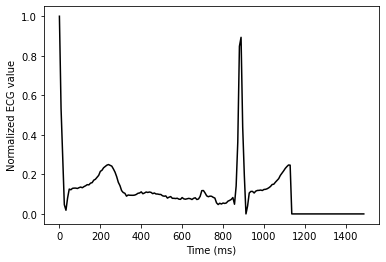

Visualize extracted beat example 926 (abnormal)


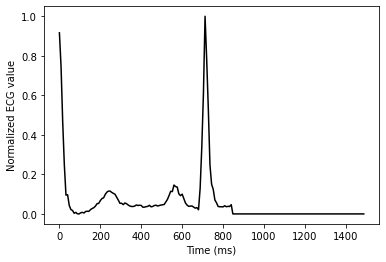

In [7]:
idx = random.choice(range(len(dfN)))
print('Visualize extracted beat example {} (healthy)'.format(idx))

waveform = dfN.iloc[idx, :].to_numpy()
visualize_waveform(waveform)

idx = random.choice(range(len(dfA)))
print('Visualize extracted beat example {} (abnormal)'.format(idx))

waveform = dfA.iloc[idx, :].to_numpy()
visualize_waveform(waveform)

The next figures visualize the mean waveforms and their corresponding standard deviations (gray bands) for the healty and abnormal classes, respectively. The two mean waveforms are not very distinct and have large dispersions, which will reduce the efficiency of the anomaly detection. The difference between the waveforms might be more visible when comparing the healthy waveform to the indiviudal diagnostic classes. For this dataset, the dominant class is myocardial infarction. We note that the distinction between the two waveforms might be improved by a different preprocessing of the raw data. 

Visualize mean waveform (healthy)


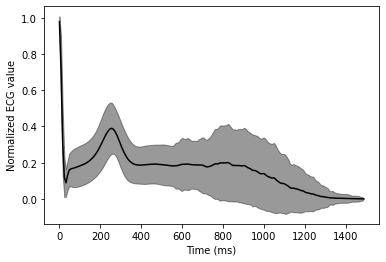

Visualize mean waveform (abnormal)


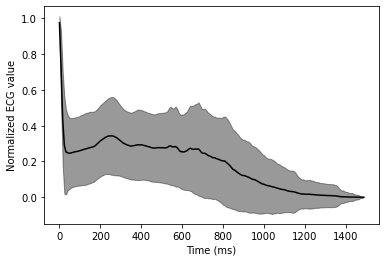

In [8]:
print('Visualize mean waveform (healthy)')
visualize_waveform(dfN.mean().to_numpy(), dfN.std().to_numpy())
print('Visualize mean waveform (abnormal)')
visualize_waveform(dfA.mean().to_numpy(), dfA.std().to_numpy())

In [9]:
# Split the dataset of healthy ECG beats into training, validation and test subsets
train_df, val_df = train_test_split(dfN, test_size=0.2)
val_df, test_df = train_test_split(val_df, test_size=0.4)

ntot = len(dfN)
print('Training: \t{:.2f}% ({})'.format(len(train_df)/ntot*100., len(train_df)))
print('Validation: \t{:.2f}% ({})'.format(len(val_df)/ntot*100., len(val_df)))
print('Test: \t\t{:.2f}% ({})'.format(len(test_df)/ntot*100., len(test_df)))

Training: 	79.98% (3236)
Validation: 	12.01% (486)
Test: 		8.01% (324)


In [10]:
def create_dataset(df):
    # This approach corresponds effectively to a batch size of 1
    # Convert to tensor
    # The unsqueeze command converts each data point in a tensor
    waveforms = df.astype(np.float32).to_numpy()
    dataset = [torch.tensor(wf).unsqueeze(1) for wf in waveforms] 
    
    n_seq, seq_len, n_features = torch.stack(dataset).shape
    
    return dataset, seq_len, n_features

In [11]:
train_dataset, seq_len, n_features = create_dataset(train_df)
val_dataset, _, _ = create_dataset(val_df)

test_N_dataset, _, _ = create_dataset(test_df)
test_A_dataset, _, _ = create_dataset(dfA)

### The LSTM autoencoder
In the encoding step, an autoencoder learns to represent the input data by a lower dimensional number of features. From this representation, the decoder step reconstructs the original input as close as possible. This way, the model learns the most important features of the data, meaning a compressed representation.
In this example, the data points of the ECG have a temporal dependency. We model this using two LSTM layers.

In [12]:
class Encoder(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim):
        super(Encoder, self).__init__()
        
        self.seq_len = seq_len
        self.n_features = n_features
        self.embedding_dim = embedding_dim
        self.hidden_dim = 2 * embedding_dim
        
        # Define two LSTM layers to encode the time series data
        self.rnn1 = nn.LSTM(
            input_size = n_features,
            hidden_size = self.hidden_dim,
            num_layers = 1,
            batch_first = True
        )
        
        self.rnn2 = nn.LSTM(
            input_size = self.hidden_dim,
            hidden_size = embedding_dim,
            num_layers = 1,
            batch_first = True
        )
    
    def forward(self, x):
        x = x.reshape((1, self.seq_len, self.n_features))
        x, (_, _) = self.rnn1(x)
        x, (hidden_n, _) = self.rnn2(x)
        return hidden_n.reshape((self.n_features, self.embedding_dim))

In [13]:
class Decoder(nn.Module):
    def __init__(self, seq_len, input_dim, n_features):
        super(Decoder, self).__init__()
        
        self.seq_len = seq_len
        self.input_dim = input_dim
        self.n_features = n_features

        self.hidden_dim = 2 * input_dim
        
        self.rnn1 = nn.LSTM(
            input_size=input_dim,
            hidden_size=input_dim,
            num_layers=1,
            batch_first=True
        )
        
        self.rnn2 = nn.LSTM(
            input_size=input_dim,
            hidden_size=self.hidden_dim,
            num_layers=1,
            batch_first=True
        )
        
        self.output_layer = nn.Linear(self.hidden_dim, n_features)
        
    def forward(self, x):
        x = x.repeat(self.seq_len, self.n_features)
        x = x.reshape((self.n_features, self.seq_len, self.input_dim))
        x, (_, _) = self.rnn1(x)
        x, (_, _) = self.rnn2(x)
        x = x.reshape((self.seq_len, self.hidden_dim))
        return self.output_layer(x)

In [14]:
class RecurrentAutoencoder(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim):
        super(RecurrentAutoencoder, self).__init__()
        self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
        self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [15]:
def load_model():
    # To track loss for each epoch
    loss_history = dict(train=[], val=[])
    
    # Learning rate
    lrn_rate = .01
        
    if os.path.isfile('model.pth'):
        # Load model and loss history
        model = torch.load('model.pth')
        loss_df = pd.read_csv('loss_history.csv', index_col=0)
        loss_history['train'] = loss_df.train.tolist()
        loss_history['val'] = loss_df.val.tolist()
        
        lrn_rate = lrn_rate * np.power(lrn_gamma, len(loss_history['val']))
        val_loss_min = np.min(loss_history['val'])
    else:
        model = RecurrentAutoencoder(seq_len, n_features, 128)
        # To track validation loss changes
        val_loss_min = np.Inf      
    
    model = model.to(device)
    return model, loss_history, val_loss_min, lrn_rate

In [26]:
lrn_gamma = 0.99

model, loss_history, val_loss_min, lrn_rate = load_model()

In [27]:
model

RecurrentAutoencoder(
  (encoder): Encoder(
    (rnn1): LSTM(1, 256, batch_first=True)
    (rnn2): LSTM(256, 128, batch_first=True)
  )
  (decoder): Decoder(
    (rnn1): LSTM(128, 128, batch_first=True)
    (rnn2): LSTM(128, 256, batch_first=True)
    (output_layer): Linear(in_features=256, out_features=1, bias=True)
  )
)

### Train the network
As input for the training, we just need the healthy waveforms. The model learns to represent this data in an unsupervised manner by minimizing the reconstruction loss. We use a standard L1 Loss function (Least Absolute Deviations) to minimize the sum of all the absolute differences between the true value and the predicted value.

In [28]:
criterion = nn.L1Loss(reduction="sum").to(device)
optimizer = optim.Adam(model.parameters(), lr=lrn_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=lrn_gamma)

In [29]:
# Specify the number of epochs to train the model
n_epochs = 10

# Set start value
n_start = len(loss_history['val'])+1

for n_loop, epoch in enumerate(range(n_start, n_start+n_epochs)):
    # Model training
    model.train()
    
    train_losses = []
    for waveform in train_dataset:
        optimizer.zero_grad()
        waveform = waveform.to(device)
        prediction = model(waveform)
        loss = criterion(prediction, waveform)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    
    # Model validation
    val_losses = []
    model.eval()
    with torch.no_grad():
        for waveform in val_dataset:
            waveform = waveform.to(device)
            prediction = model(waveform)
            loss = criterion(prediction, waveform)
            val_losses.append(loss.item())
    
    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)
    
    loss_history['train'].append(train_loss)
    loss_history['val'].append(val_loss)
    
    # Save the model if validation loss decreases
    if val_loss < val_loss_min:
        torch.save(model, 'model.pth')
        val_loss_min = val_loss
    
    # Adjust learning rate
    curr_lr = scheduler.get_last_lr()
    scheduler.step()
    
    if n_loop == 0:
        print('Epoch \tTraining loss \tValidation loss \tLearning rate\n')
              
    print('{} \t{:.4f} \t{:.4f} \t\t{:.4f}'.format(epoch,train_loss, val_loss, curr_lr[0]))

loss_df = pd.DataFrame.from_dict(loss_history)
loss_df.to_csv('loss_history.csv', index=True)

11 	28.2708 	27.8928 		0.0090
12 	28.2097 	29.1774 		0.0090
13 	27.9230 	28.4031 		0.0089
14 	28.2040 	30.7012 		0.0088
15 	28.3351 	28.3568 		0.0087
16 	27.9865 	23.0098 		0.0086
17 	28.0558 	25.8536 		0.0085
18 	27.9899 	27.2267 		0.0084
19 	27.3876 	22.7765 		0.0083
20 	28.0168 	24.7474 		0.0083


### Visualize loss history
In this first run, the training loss decreases with the number of epochs, which is desired. However, the number of epochs needs to be increased for convergence. The validation loss scatters a lot, indicating that the validation set is too small. Here, we are interested in the implementation of the LSTM autoencoder and do not continue training the model to improve the results.

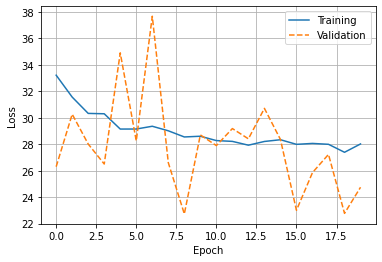

In [30]:
epochs = loss_df.index.tolist()

plt.clf()

plt.plot(epochs, loss_df['train'].to_numpy(), ls='-', label='Training')
plt.plot(epochs, loss_df['val'].to_numpy(), ls='--', label='Validation')

plt.xlabel("Epoch")
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

### Evaluate the training datasets
We choose a threshold of the reconstruction error (the loss) to make the prediction whether a heartbeat is an anomaly or not. First, we visualize the distribution of the losses of the training dataset. The majority of the waveforms are reconstructed with a loss below 30.
Therefore, we classify heartbeats below this threshold as healthy and heartbeats with larger losses as anomalies. This choice is a trade-off between precision and sensitivity towards a given class and needs to be fine-tuned for a real world task. For example, one can be more conservative by lowering the threshold. This would result in more false positives. On the other hand, increasing the threshold will reduce the number of false positives but increase the probability to miss actual anomalies.

We note again, that the model is not converged and thus the reconstruction-loss distribution is broad and a large number of heartbeats have a large reconstruction loss.

In [31]:
def make_pretiction(dataset, model):
    predictions, losses = [], []
    
    model.eval()
    with torch.no_grad():
        for waveform in dataset:
            waveform.to(device)
            prediction = model(waveform)
            loss = criterion(prediction, waveform)
            
            predictions.append(prediction.cpu().numpy().flatten())
            losses.append(loss.item())
    return predictions, losses

In [32]:
_, train_losses = make_pretiction(train_dataset, model)

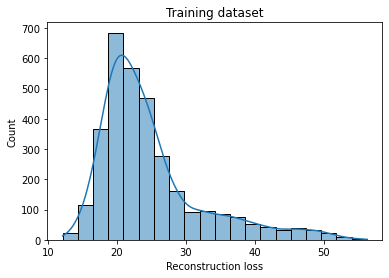

In [37]:
ax = sns.histplot(data=train_losses, bins=20, kde=True)
ax.set(xlabel='Reconstruction loss', ylabel='Count', title='Training dataset')
plt.show()

In [38]:
test_N_pred , test_N_losses = make_pretiction(test_N_dataset, model)
# Use a subset of the anomaly set for quick testing
test_A_pred , test_A_losses = make_pretiction(test_A_dataset[:len(test_N_dataset)], model)

In [39]:
threshold = 30.

test_losses = np.concatenate((test_N_losses, test_A_losses))
prediction = [0 if loss <= threshold else 1 for loss in test_losses]

label = np.concatenate((np.zeros(len(test_N_losses)), np.ones(len(test_A_losses))))

### Accuracy, Precision, Recall & F1-Score
In our example, a label of 1 (positive) represents the anomalies.

#### True Negatives:
Number of correctly predicted negatives out of all negatives in the test dataset

#### False Positives:
Number of incorrect positive predictions

#### False Negatives:
Number of incorrect negative predictions

#### True Positives:
Number of correctly predicted positives out of all positves in the test dataset

In [46]:
conf_matrix = confusion_matrix(y_true=label, y_pred=prediction)
matrix_label = ['True Negatives', 'False Positives', 'False Negatives', 'True Positives']

for ml, cm in zip(matrix_label, conf_matrix.ravel()):
    print('{}: \t{}'.format(ml,cm))

True Negatives: 	277
False Positives: 	47
False Negatives: 	191
True Positives: 	133


#### Precision score:
Represents the model’s ability to correctly predict positives:
Precision = TP / (FP + TP)

#### Recall score:
Represents the model’s ability to correctly predict positives out of actual positives:
Recall = TP / (FN + TP)

#### Accuracy score:
Represents the model’s ability to correctly predict positives and negatives out of all predictions:
Accuracy = (TP + TN)/ (TP + FN + TN + FP)

#### F1 score:
Represents a weighted average of precision and recall:
F1 = 2 x Precision x Recall / (Precision + Recall)

In [50]:
print('Precision: \t{:.3f}'.format(precision_score(label, prediction)))
print('Recall: \t{:.3f}'.format(recall_score(label, prediction)))
print('Accuracy: \t{:.3f}'.format(accuracy_score(label, prediction)))
print('F1: \t\t{:.3f}'.format(f1_score(label, prediction)))

Precision: 	0.739
Recall: 	0.410
Accuracy: 	0.633
F1: 		0.528
